<a href="https://colab.research.google.com/github/jchen8000/GenerativeAI/blob/main/3_Transformer/Transformer_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Transformer

Implementation from scratch




In [1]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.nn.utils.rnn import pad_sequence

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epochs = 100
torch.manual_seed(999)
batch_size = 8
learning_rate=1e-3
d_model = 512
d_ff = 2048
d_k = d_v = 64
n_layers = 6
n_heads = 8

## 3.1	Dataset and Tokenization

In [3]:
#
# Question and Answer Dataset
# https://www.kaggle.com/datasets/rtatman/questionanswer-dataset/
# File: S08_question_answer_pairs.txt
#
question_answer = [
  ['What are the similarities between the beetles and the grasshoppers?',  'Beetles have the mouthparts that are similar to those of the grasshoppers.'],
  ['What land animal is larger than an elephant?',  'None, the elephant is the largest land animal in the world.'],
  ['How often do turtles breed?',  'Every few years or more.'],
  ['Where do sea turtles lay their eggs?',  'Holes dug into mud or sand.'],
  ['How do otters keep themselves warm without blubber?',  'A layer of air trapped in their fur.'],
  ['How much time to penguins spend on land?',  'They spend half of their life on land.'],
  ['What are the three sections of a beetle?',  'The head, the thorax, and the abdomen.'],
  ['Can polar bears be seen under infrared photography?',  'Polar bears are nearly invisible under infrared photography.'],
  ['What do fossil and DNA evidence tell us?',  'The polar bear diverged from the brown bear roughly 200 thousand years ago.'],
  ['On average are cougar males heavier than females?',	'On average the cougar males are heavier than the females.'],
  ['How are Isabelline penguins different from most penguins?',  'Because they are born with brown rather than black plumage.'],
  ['What do beetles eat?',  'They often feed on plants and fungi, break down animal and plant debris, and eat other invertebrates.'],
  ['What are the similarities between beetles and grasshoppers?',  'Beetles have mouthparts similar to those of grasshoppers.'],
  ['How much do elephants weight at birth?',  'At birth it is common for an elephant calf to weigh 120 kilograms or 265 lb.'],
  ['How do elephants communicate over long distances?',  'By producing and receiving low-frequency sound or infrasound.'],
  ['What makes penguins so agile in the water?',  'Smooth plumage preserves a layer of air, ensuring buoyancy, wings are flippers.'],
]

texts = []
for que_text, ans_text in question_answer:
  text = que_text.replace('?', ' ?')
  texts.extend(text.split())
  text = ans_text.replace('.', ' .')
  texts.extend(text.split())

# Special tokens:
#   <PAD>: Padding token
#   <UNK>: Unknown token
#   <SOS>: Start-of-Sequence token
#   <EOS>: End-of-Sequence token
words = sorted(list(set(texts)))
words = ['<PAD>', '<UNK>','<SOS>','<EOS>'] + words

class Tokenizer():
    def __init__(self, vocabulary):
      self.idx2word = {index:word for index, word in enumerate(vocabulary)}
      self.word2idx = {word:index for index, word in enumerate(vocabulary)}

    def get_vocab_size(self):
      return len(self.idx2word)

    def encode(self, text):
      return [self.word2idx[w] for w in text.split()]

    def encode_word(self, char):
      return self.word2idx[char]

    def decode(self, encoded_text):
      return [self.idx2word[i] for i in encoded_text]

    def decode_text(self, encoded_text):
      s = self.decode(encoded_text)
      return (" ".join(s))

tokenizer = Tokenizer(words)

vocab_size = tokenizer.get_vocab_size()


In [4]:
def make_data(sentences):
    enc_inputs, dec_inputs, dec_outputs = [], [], []

    for i in range(len(sentences)):
        que_text = sentences[i][0].replace('?', ' ?')
        ans_text_inp = '<SOS> ' + sentences[i][1].replace('.', ' .')
        ans_text_out = sentences[i][1].replace('.', ' .') + ' <EOS>'

        enc_input = tokenizer.encode(que_text)
        dec_input = tokenizer.encode(ans_text_inp)
        dec_output = tokenizer.encode(ans_text_out)

        enc_inputs.append(torch.LongTensor(enc_input))
        dec_inputs.append(torch.LongTensor(dec_input))
        dec_outputs.append(torch.LongTensor(dec_output))

    return pad_sequence(enc_inputs, batch_first=True), pad_sequence(dec_inputs, batch_first=True), pad_sequence(dec_outputs, batch_first=True)

enc_inputs, dec_inputs, dec_outputs = make_data(question_answer)

In [5]:
class DataSet(Data.Dataset):
    def __init__(self, data):
        super(DataSet, self).__init__()
        self.data = data

    def __len__(self):
        return self.data[0].shape[0]

    def __getitem__(self, idx):
        return [x[idx] for x in self.data]

loader = Data.DataLoader( DataSet([enc_inputs, dec_inputs, dec_outputs]), batch_size, True)

## 3.3	Positional Encoding

Based on the paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf), Positional Encoding is defined as:

$PE_{(pos, 2i)}=\sin{\left( \frac{pos}{10000^{2i/d_{model}}} \right)}$

$PE_{pos, 2i+1}=\cos{\left( \frac{pos}{10000^{2i/d_{model}}} \right)}$

where:

$pos$: is the position of an item in the input sequence, $0 \leqslant  pos \lt  \frac{len(input)}{2}$

$d_{model}$: Dimension of the embedding space

It's implemented as below:

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe_table', pe)

    def forward(self, x):
        x = x + self.pe_table[:, :x.size(1), :]
        return self.dropout(x)

## 3.4	Layer Normalization



**Layer Normalization** is based on the paper of [Layer Normalization](https://arxiv.org/abs/1607.06450), it can be implemented with *torch.nn.LayerNorm()*.

Here we do our implementation, it is defined as:

$$y = \displaystyle \frac{x-E\left[ x \right]}{\sqrt{Var\left[ x \right]+\epsilon}}\ast \gamma + \beta$$



$E$ is the mean of $x$,

$Var$ is the standard-deviation of $x$

Both mean and standard-deviation are calculated over the last dimension of $x$, and calculated by:

```
mean = x.mean(dim = -1, keepdim = True),
std = x.std(dim = -1, keepdim = True)
```

$\gamma$ and $\beta$ are learnable parameters.

$\epsilon$ is to prevent dividing by zero or when std is near zero, default is 1e-5.

In [7]:
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-5) -> None:
        super(LayerNorm, self).__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(features)) # gamma is a learnable parameter
        self.beta = nn.Parameter(torch.zeros(features)) # beta is a learnable parameter

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

## 3.5	Feed Forward

**Position-wise Feed-Forward Networks**, based on the paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf), is defined as:

$$FFN(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

This consists of two linear transformations with a *ReLU* activation in between.



In [8]:
class FeedForward(nn.Module):
    def __init__(self, d_ff, dropout=0.2):
        super(FeedForward, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model, bias=False)
        )
        self.ln = LayerNorm(d_model)

    def forward(self, x):
        residual = x
        output = self.fc(x)
        return self.ln(output+residual)


## 3.6	Scaled Dot-Product Attention

Based on the paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf), the input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the
values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$. We compute
the matrix of outputs as:

$$Attention(Q, K, V)=softmax \left( \frac{QK^T}{\sqrt{d_k}} \right) V$$




In [9]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.2):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, Q, K, V, mask=None):
        attn_logits = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        if mask is not None:
            attn_logits = attn_logits.masked_fill_(mask, -float('inf'))
        scores = nn.Softmax(dim=-1)(attn_logits)
        scores = self.dropout(scores)
        attention = torch.matmul(scores, V)
        return attention, scores

## 3.7	Mask

In [10]:
class Mask(nn.Module):
    def get_attn_pad_mask(self, seq_q, seq_k, pad=0):
        batch_size, len_q = seq_q.size()
        batch_size, len_k = seq_k.size()
        pad_attn_mask = seq_k.data.eq(pad).unsqueeze(1)
        return pad_attn_mask.expand(batch_size, len_q, len_k)

    def get_attn_subsequence_mask(self, seq):
        attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
        subsequence_mask = torch.triu(torch.ones(attn_shape), diagonal=1)
        subsequence_mask.bool()
        return subsequence_mask

## 3.8	Multi-Head Attention

Multi-head Attention is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension. It's defined as:

$$Multihead(Q, K, V) = Concat(head_1, ..., head_h)\cdot W$$

where: $head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)$



In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, dropout=0.2):
        super(MultiHeadAttention, self).__init__()
        self.d_model, self.n_heads = d_model, n_heads
        self.d_k, self.d_v = d_k, d_v

        self.W_Q = nn.Linear(d_model, self.d_k * self.n_heads, bias=False)
        self.W_K = nn.Linear(d_model, self.d_k * self.n_heads, bias=False)
        self.W_V = nn.Linear(d_model, self.d_v * self.n_heads, bias=False)

        self.fc = nn.Linear(self.n_heads * self.d_v, d_model, bias=False)
        self.ln = LayerNorm(self.d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_Q, input_K, input_V, attn_mask):
        n_heads, d_k, d_v = self.n_heads, self.d_k, self.d_v
        residual, batch_size = input_Q, input_Q.size(0)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1, 2)
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1, 2)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v)
        output = self.dropout(self.fc(context))
        return self.ln(output + residual), attn


## 3.9	Encoder Layer and Encoder

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = FeedForward(d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, _i = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding( d_model, max_len = vocab_size )
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])
        self.mask = Mask()

    def forward(self, enc_inputs):
        enc_outputs = self.src_emb(enc_inputs)
        enc_outputs = self.pos_emb(enc_outputs).to(device)
        enc_self_attn_mask = self.mask.get_attn_pad_mask(enc_inputs, enc_inputs).to(device)
        for layer in self.layers:
            enc_outputs = layer(enc_outputs, enc_self_attn_mask)
        return enc_outputs


## 3.10	Decoder Layer and Decoder

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = FeedForward(d_ff)

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, _ = self.dec_self_attn(dec_inputs,
                                            dec_inputs,
                                            dec_inputs,
                                            dec_self_attn_mask)

        dec_outputs, _ = self.dec_enc_attn(dec_outputs,
                                           enc_outputs,
                                           enc_outputs,
                                           dec_enc_attn_mask)

        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_len = vocab_size )
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
        self.mask = Mask()

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        dec_outputs = self.tgt_emb(dec_inputs)
        dec_outputs = self.pos_emb(dec_outputs).to(device)
        dec_self_attn_pad_mask = self.mask.get_attn_pad_mask(dec_inputs, dec_inputs).to(device)
        dec_self_attn_subsequence_mask = self.mask.get_attn_subsequence_mask(dec_inputs).to(device)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0).to(device)
        dec_enc_attn_mask = self.mask.get_attn_pad_mask(dec_inputs, enc_inputs)

        for layer in self.layers:
            dec_outputs = layer(dec_outputs, enc_outputs,
                                dec_self_attn_mask, dec_enc_attn_mask)
        return dec_outputs

## 3.11	Transformer

In [14]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.projection = nn.Linear(
            d_model, vocab_size, bias=False).to(device)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc_inputs, dec_inputs):
        enc_outputs = self.encoder(enc_inputs)
        dec_outputs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs)
        return dec_logits.view(-1, dec_logits.size(-1))



## 3.12	Training

In [15]:
model = Transformer().to(device)
# print the number of parameters in the model
total_parameter = sum(p.numel() for p in model.parameters())
print(f"Parameters of the model: {total_parameter:,}")


Parameters of the model: 44,324,352


In [16]:
# Print out the structure of the Transformer model
print(model)

Transformer(
  (encoder): Encoder(
    (src_emb): Embedding(165, 512)
    (pos_emb): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (enc_self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=False)
          (W_K): Linear(in_features=512, out_features=512, bias=False)
          (W_V): Linear(in_features=512, out_features=512, bias=False)
          (fc): Linear(in_features=512, out_features=512, bias=False)
          (ln): LayerNorm()
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (pos_ffn): FeedForward(
          (fc): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=False)
            (1): ReLU()
            (2): Dropout(p=0.2, inplace=False)
            (3): Linear(in_features=2048, out_features=512, bias=False)
          )
          (ln): LayerNorm()
        )
      )
    )
    (mask): Mask()
  )
  (dec

In [17]:
# Loss function to ignore the word "<P>" which marks the end of a sentance.
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.encode_word("<PAD>"))
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99)

In [18]:
history_loss = []
for epoch in range(epochs):
    for i, [enc_inputs, dec_inputs, dec_outputs] in enumerate(loader):
        enc_inputs =  enc_inputs.to(device)
        dec_inputs =  dec_inputs.to(device)
        dec_outputs = dec_outputs.to(device)
        outputs = model(enc_inputs, dec_inputs)
        loss = criterion(outputs, dec_outputs.view(-1))

        print('Epoch:', '%d/%d' % (i+1, epoch+1), 'loss =', '{:.6f}'.format(loss))
        history_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch: 1/1 loss = 5.287929
Epoch: 2/1 loss = 5.311439
Epoch: 1/2 loss = 5.269698
Epoch: 2/2 loss = 5.221197
Epoch: 1/3 loss = 5.091483
Epoch: 2/3 loss = 4.971140
Epoch: 1/4 loss = 4.875039
Epoch: 2/4 loss = 4.724355
Epoch: 1/5 loss = 4.603537
Epoch: 2/5 loss = 4.648116
Epoch: 1/6 loss = 4.632385
Epoch: 2/6 loss = 4.540625
Epoch: 1/7 loss = 4.617231
Epoch: 2/7 loss = 4.416563
Epoch: 1/8 loss = 4.468247
Epoch: 2/8 loss = 4.396354
Epoch: 1/9 loss = 4.325215
Epoch: 2/9 loss = 4.272070
Epoch: 1/10 loss = 4.106296
Epoch: 2/10 loss = 4.223099
Epoch: 1/11 loss = 4.048276
Epoch: 2/11 loss = 4.176880
Epoch: 1/12 loss = 4.253010
Epoch: 2/12 loss = 4.038179
Epoch: 1/13 loss = 4.061227
Epoch: 2/13 loss = 4.140214
Epoch: 1/14 loss = 3.923707
Epoch: 2/14 loss = 4.102126
Epoch: 1/15 loss = 4.010428
Epoch: 2/15 loss = 3.888299
Epoch: 1/16 loss = 3.996034
Epoch: 2/16 loss = 3.572006
Epoch: 1/17 loss = 3.788320
Epoch: 2/17 loss = 3.476848
Epoch: 1/18 loss = 3.626778
Epoch: 2/18 loss = 3.450387
Epoch: 1/1

### Visualize the train losses

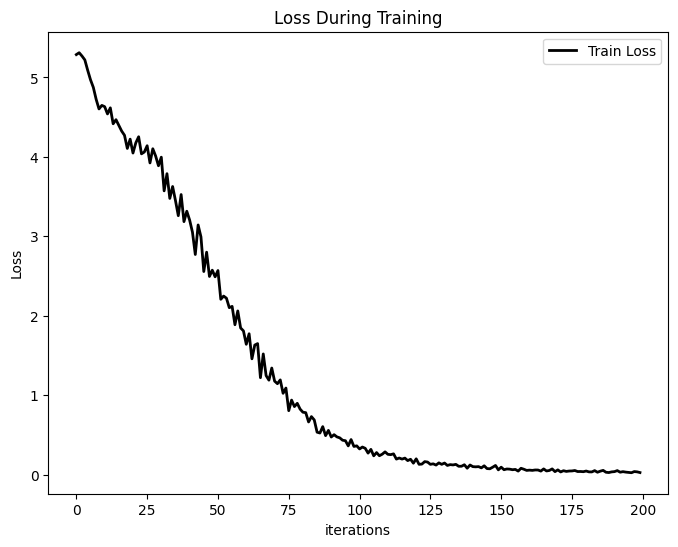

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.title("Loss During Training")
plt.plot(history_loss, label="Train Loss", c='k', lw=2)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Training.svg", format="svg", dpi=150, transparent=True, bbox_inches='tight')
plt.show()

## 3.13	Inference

In [20]:
def Greedy(logits):
    return torch.argmax(logits, dim=-1, keepdim=False)

def RandomSampling(logits, k=5):
    top_k_probs, _ = torch.topk(logits, k, dim=-1)
    kth_highest_prob = top_k_probs[:, -1].unsqueeze(-1)
    mask = logits < kth_highest_prob
    probs = logits.masked_fill(mask, 0)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

def Inference(model, enc_input, start_token, end_token, max_len=32, topk=None):
    enc_outputs = model.encoder(enc_input)
    dec_input = torch.zeros(1, 0).type_as(enc_input.data)
    next_token = start_token
    cnt = 0
    while next_token != end_token and cnt < max_len:
        dec_input = torch.cat([dec_input.to(device),
                               torch.tensor([[next_token]], dtype=enc_input.dtype).to(device)], -1)
        dec_outputs = model.decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        projected = model.softmax(projected)
        if topk == None:
          prob = Greedy(projected.squeeze(0))
        else:
          prob = RandomSampling(projected.squeeze(0), topk)
        next_word = prob.data[-1]
        next_token = next_word
        cnt += 1
    return prob


In [21]:
evaluation = [
  ['How similar between the beetles and the grasshoppers?', ''],
  ['What animal larger than elephant?', ''],
  ['What years do turtles breed?',  ''],
  ['Where turtles lay eggs?', ''],
  ['How do otters keep warm?', ''],
  ['How long do penguins on land?', ''],
  ['What sections do beetles have?', ''],
  ['Can infrared photography seen polar bears?', ''],
  ['DNA evidence and fossil tell us What?', ''],
  ['are cougar males heavier than females?', ''],
  ['How Isabelline penguins different?', ''],
  ['Beetles eat What?', ''],
  ['How similar between beetles and grasshoppers?', ''],
  ['What elephants weight at birth?', ''],
  ['How do elephants communicate over distances?', ''],
  ['What do penguins agile in water?', ''],
]

evl_enc_inputs, _, _ = make_data(evaluation)
evl_loader = Data.DataLoader(DataSet([evl_enc_inputs]), 16, True)
[evl_enc_inputs] = next(iter(evl_loader))

for i in range(len(evl_enc_inputs)):
    predict = Inference(model,
                        evl_enc_inputs[i].view(1, -1).to(device),
                        start_token=tokenizer.encode_word("<SOS>"),
                        end_token=tokenizer.encode_word("<EOS>"),
                        topk=None)
    q = evl_enc_inputs[i].tolist()
    q = [x for x in q if x != tokenizer.encode_word("<PAD>")]
    question = tokenizer.decode_text(q)
    answer = tokenizer.decode_text(predict.tolist())
    question = question.replace(" ?", "?")
    answer = answer.replace(" .", ".").replace("<EOS>", "")
    print(question, '->', answer)

Where turtles lay eggs? -> Holes dug into mud or sand. 
How Isabelline penguins different? -> Because they are born with brown rather than black plumage. 
How do otters keep warm? -> A layer of air trapped in their fur. 
How similar between the beetles and the grasshoppers? -> Beetles have mouthparts mouthparts that are similar to those of the grasshoppers. 
Can infrared photography seen polar bears? -> Polar bears are nearly invisible under infrared photography. 
How long do penguins on land? -> They spend half of their life on land. 
DNA evidence and fossil tell us What? -> The polar bear diverged from the brown bear roughly 200 thousand years ago. 
What years do turtles breed? -> Every few years or more. 
are cougar males heavier than females? -> On average the cougar males are heavier than the females. 
Beetles eat What? -> They often feed on plants and fungi, break down animal and plant debris, and eat other invertebrates. 
How similar between beetles and grasshoppers? -> Beetles 

## References:

1.   *https://nlp.seas.harvard.edu/annotated-transformer/*
1.   *https://github.com/jadore801120/attention-is-all-you-need-pytorch*
2.   *https://github.com/JayParks/transformer*
3.   *https://www.freecodecamp.org/news/how-to-build-a-large-language-model-from-scratch-using-python/*
4.   *https://mdnice.com/writing/fc0b920d4ca84837a5712df1a46865d2*